In [2]:
from Obstacle import *
from Visualization import *
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from Utils.Node import *
import math
import queue
import random
import copy

wheel_radius = 0.038
wheel_distance = 0.354

In [3]:
def halfRound(n):
    return round(2*n)/2
def toRadian(angle):
    return np.pi * angle / 180
def toDegree(angle):
    return 180 * angle / np.pi

In [4]:
# Чтобы найти угол между отрезком, заданным двумя точками xi, yi и xn, yn
# и горизонтальной осью используем функцию арктангенс.
# Вычисленный угол определяет поворот прямоугольника
def calculate_angle(xi, yi, xn, yn):
    angle_rad = np.arctan2(yn - yi, xn - xi)
    angle_deg = np.degrees(angle_rad)
    return angle_deg


# Для рисования прямоугольника из четырех линий с возможностью поворота
# определим функцию draw_rotated_rectangle(),
# которая будет принимать координаты центра прямоугольника,
# его ширину, высоту и угол поворота.
def draw_rotated_rectangle(center_x, center_y, width, height, angle):
    # Вычисляем углы вершин прямоугольника
    angle_rad = np.radians(angle)
    cos_angle = np.cos(angle_rad)
    sin_angle = np.sin(angle_rad)

    # Вычисляем координаты вершин прямоугольника
    x1 = center_x - width/2 * cos_angle - height/2 * sin_angle
    y1 = center_y - width/2 * sin_angle + height/2 * cos_angle

    x2 = center_x + width/2 * cos_angle - height/2 * sin_angle
    y2 = center_y + width/2 * sin_angle + height/2 * cos_angle

    x3 = center_x + width/2 * cos_angle + height/2 * sin_angle
    y3 = center_y + width/2 * sin_angle - height/2 * cos_angle

    x4 = center_x - width/2 * cos_angle + height/2 * sin_angle
    y4 = center_y - width/2 * sin_angle - height/2 * cos_angle

    ALPHA = 0.2

    # Рисуем прямоугольник из четырех линий
    # plt.plot([x1, x2], [y1, y2], color='r', alpha=ALPHA)
    # plt.plot([x2, x3], [y2, y3], color='r', alpha=ALPHA)
    # plt.plot([x3, x4], [y3, y4], color='r', alpha=ALPHA)
    # plt.plot([x4, x1], [y4, y1], color='r', alpha=ALPHA)

    # Нарисовать залитый многоугольник по вершинам
    vertices = [(x1, y1), (x2, y2), (x3, y3), (x4, y4)]
    plt.fill(*zip(*vertices), color='red', alpha=ALPHA)

In [5]:
def visualize(viz, traversed_nodes, destination, goal_node, obs, show_pass):
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set(xlim=(0, 10), ylim = (0,10))
    ax = viz.addObstacles2Map(ax)
    ax.set_aspect("equal")
    c = 0
    print(len(traversed_nodes))
    if show_pass:
        for node in traversed_nodes:
            start_node  = node.getParent()
            if start_node is not None:
                xi, yi, _, _ = start_node.getState()
                points = node.getPathArray()
                if points is not None:
                    for point in points:
                        xn, yn = point
                        ax.plot([xi, xn], [yi, yn], color="blue", linewidth = 0.3)
                        xi, yi = xn, yn

    # i = 0
    # y = goal_node.getState()[1]
    # y_ = goal_node.getState()[1]
    # ax.scatter(goal_node.getState()[0], y)
    # theta = toRadian(goal_node.getState()[2])
    # while(i<10):
    #     if goal_node.getState()[2] % 90 == 0:
    #         x = goal_node.getState()[0]
    #     else:
    #         x = y/math.tan(theta)
    #     i+=1
    #     y+=0.1
    #     y_-=0.1
    #     ax.scatter(x,y)
    #     ax.scatter(x,y_)

    x, y = goal_node.getState()[:2]
    x_, y_ = goal_node.getState()[:2]
    theta = toRadian(goal_node.getState()[2])
    ax.scatter(x,y)
    d = 1
    x = x + d*math.cos(theta)
    y = y + d*math.sin(theta)
    #x_ = x_ - d*math.cos(theta)
    #y_ = y_ - d*math.sin(theta)
    ax.plot([x, x_], [y, y_], color="red", linewidth = 5)


    current_node = copy.copy(destination)
    nodes = []
    while(current_node.getParent() is not None):
        nodes.append(current_node)
        current_node = current_node.getParent()
    nodes.append(current_node)
    nodes.reverse()

    for node in nodes:
        start_node  = node.getParent()
        
        if start_node is not None:
            xi, yi, _, _ = start_node.getState()
            points = node.getPathArray()
            if points is not None:
                for point in points:
                    xn, yn = point[:2]                  
                    ax.plot([xi, xn], [yi, yn], color="green", linewidth = 2)
                    if ((xi != xn) and (yi != yn)):
                        draw_rotated_rectangle(xi, yi, 0.4, 0.2, calculate_angle(xi, yi, xn, yn))
                    xi, yi = xn, yn
        
    a = str(int(random.uniform(1,1000)))
    plt.savefig(a + '.png')
    return nodes


In [6]:
def getBranches(node, T, u_linear, u_steer1, u_steer2, obs):
    actions=[[u_linear, 0], [u_linear, u_steer1], [u_linear, -u_steer1], [u_linear, u_steer2], [u_linear, -u_steer2],[-u_linear, 0], [-u_linear, u_steer1], [-u_linear, -u_steer1], [-u_linear, u_steer2], [-u_linear, -u_steer2]]
    state = node.getState()
    branches = []

    for action in actions:
        new_state, path_array, cost = move(state, action, T, obs)
        if new_state is not None:
            branch_node = Node(new_state, node, action, node.getCost() + cost, path_array)
            branches.append(branch_node)
              
    return branches

In [7]:
def isOnSpot(current, final):
    x_current, y_current, theta_current = current.getState()[:3]
    x_goal, y_goal, theta_goal = final.getState()[:3]

    theta_goal = toRadian(theta_goal)
    theta_current = toRadian(theta_current)
    
    m  = math.tan(theta_goal)
    if abs(theta_goal) == 90 or abs(theta_goal) == 270:
        c = 0
    else:
        c = y_goal - x_goal*m
    
    # print(abs(theta_goal), ((abs(theta_goal) > 265 and abs(theta_goal) < 275) or (abs(theta_goal) > 85 and abs(theta_goal) < 95)))

    if ((abs(theta_goal) > toRadian(265) and abs(theta_goal) < toRadian(275)) or (abs(theta_goal) > toRadian(85) and abs(theta_goal) < toRadian(95))):
    # if abs(theta_goal) > 265 or abs(theta_goal) < 275 or abs(theta_goal) > 85 or abs(theta_goal) < 95:
        error = x_current - x_goal
    else:
        error = y_current - x_current*math.tan(theta_goal) - c
    d, _ = calculate_d_and_theta(current.getState(), final.getState())
    # print(d)
    # print(error)
    # print(_)
    return (abs(error) < 1 and d < 1)

In [8]:
def move(state, action, T, obs):
    t = 0
    dt = 0.1
    
    Xi, Yi, thetai, steeri = state
    thetai = toRadian(thetai)
    steeri = toRadian(steeri)

    u_linear, u_steer = action 

    Xn = Xi
    Yn = Yi
    thetan = thetai
    steern = steeri

    path_array = []
    cost = 0.0
    path_array.append([Xn, Yn])
    a = 1
    while t<T:
        t = t + dt
        steern += dt * u_steer
        if steern > np.pi / 4:
            steern = np.pi / 4
        if steern < -np.pi / 4:
            steern = -np.pi / 4

        thetan += (np.tan(steern) / a ) * u_linear * dt
        dx = u_linear * math.cos(thetan) * dt
        dy = u_linear * math.sin(thetan) * dt

        Xn += dx
        Yn += dy

        cost += math.sqrt(math.pow(dx,2) + math.pow(dy,2))
        path_array.append([Xn, Yn])

        if obs.isInObstacleSpace(Xn, Yn):
            return None, None, None
        
    thetan = int(toDegree(thetan))
    steern = int(toDegree(steern))
    return [Xn, Yn, thetan, steern] , path_array, cost

In [9]:
def getRandomNode():
    a = random.uniform(-np.pi, np.pi)
    # print(a)
    state = [random.uniform(0, 9), random.uniform(0,9), random.uniform(0, 360), 0]
    return Node(state, None, None, None, None)

def getNearestNodeIndex(node_list, random_point):
    distance = []
    # print(random_point)
    for node in node_list:
        node_pts = node.getState()
        alpha = 0.2
        d = (((node_pts[0] - random_point[0])**2 + (node_pts[1] - random_point[1])**2) + alpha *(np.abs(node_pts[2] - random_point[2]))) ** 0.5
        distance.append(d)
    min_idx = distance.index(min(distance))

    return min_idx

def calculate_d_and_theta(start, end):
    dx = end[0] - start[0]
    dy = end[1] - start[1]
    d = math.hypot(dx, dy)
    theta = math.atan2(dy, dx)
    return d, theta

def getNewNode(nearest_node, random_point, obs):
    T = 1
    u_linear = 1
    u_steer1 = 0.2
    u_steer2 = 0.5
    sample_distance = 0.25

    nearest_point = nearest_node.getState()

    if obs.isInObstacleSpace(nearest_point[0], nearest_point[1]):
        print('Nearest point in OBSTACLE SPACE')
    
    _, theta = calculate_d_and_theta(nearest_point, random_point)
    ref_state = [sample_distance*math.cos(theta), sample_distance*math.sin(theta), random_point[2], 0]

    branches = getBranches(nearest_node, T, u_linear, u_steer1, u_steer2, obs)
    if (len(branches) > 0):
        branch_idx = getNearestNodeIndex(branches, ref_state)
        new_node = branches[branch_idx]
    else:
        new_node = None

    return new_node


In [10]:
height, width = 10, 10
T = 1
dt = 0.1
threshold = 0.5
rand_map = [width-1, height-1]
# start_point = [9,9,180,0]
#start_point = [8,6,180,0]
start_point = [8,2,90,0]
#start_point = [2,1,90,0]
#start_point = [8,6,0,0]
#start_point = [8,2,90,0]
#start_point = [9,7,90,0]
#start_point = [1,5,180,0]
#goal_state = [4.5,2,90,0]
#goal_state = [4.5,2,270,0]
#goal_state = [8,2,90,0]
#goal_state = [2,4.5,0,0]
goal_state = [1.5,4,90,0]
obs = Obstacle(0.0)
#obs.addNewObstacle(4, 4, 0.5, 0.5)
viz = Visualization(obs)

node_array = np.array([[[math.inf for k in range(360)] for j in range(int(height/threshold))] for i in range(int(width/threshold))])

goal_reached = False
start_node = Node(start_point, None, None, 0, [])
goal_node = Node(goal_state, None, None, math.inf, [])
final_node = None
node_list = [start_node]
goal_node_final = None
destination = None

for i in range(3000):
    random_node = getRandomNode()
    if (random_node == None):
        continue
    # ax.scatter(random_node.getState()[0], random_node.getState()[1])
    nearest_idx = getNearestNodeIndex(node_list, random_node.getState())
    nearest_node = node_list[nearest_idx]
    new_node = None
    new_node = getNewNode(nearest_node, random_node.getState(), obs)
    if (new_node == None):
        continue

    node_list.append(new_node)
    x_new = int(halfRound(new_node.getState()[0])/threshold)
    y_new = int(halfRound(new_node.getState()[1])/threshold)
    d_goal = ((node_list[-1].getState()[0]- goal_state[0])**2 + (node_list[-1].getState()[1]- goal_state[1])**2)**0.5 
    d_angle = np.abs((node_list[-1].getState()[2]- goal_state[2]))

    is_on_spot = isOnSpot(node_list[-1], goal_node) 
    if (is_on_spot and d_angle <= 5):
        print('Final node get state = ',new_node.getState())
        if not obs.isInObstacleSpace(new_node.getState()[0], new_node.getState()[1]):
            print('Goal Reached, cost = ', new_node.getCost())
            x_goal = int(halfRound(goal_node.getState()[0])/threshold)
            y_goal = int(halfRound(goal_node.getState()[1])/threshold)
            print(node_array[x_goal, y_goal, 0])

            dist, angle = calculate_d_and_theta(node_list[-1].getState()[:2], goal_node.getState()[:2])
            delta_angle = abs(angle-goal_node.getState()[2])
            new_cost = dist + 0.1*delta_angle
            # new_node.cost += new_cost
            # print('New cost = ', new_node.getCost())

            if (new_node.getCost() <  node_array[x_goal, y_goal, 0]):
                print('Update final node cost, state = ', x_goal, ', ',y_goal)
                print('from: ', node_array[x_goal, y_goal, 0], ' to :', new_node.getCost())
                node_array[x_goal,y_goal,0] = new_node.getCost() 
                goal_node_final = new_node
            print('------------------------')

# steer to goal
if goal_node_final is not None:
    node_list.append(goal_node_final)
    destination = getNewNode(goal_node_final, goal_node.getState(), obs)
    node_list.append(destination)

Final node get state =  [2.127000846499477, 4.387419524174017, 90, 13]
Goal Reached, cost =  14.299999999999997
inf
Update final node cost, state =  3 ,  8
from:  inf  to : 14.299999999999997
------------------------
Final node get state =  [2.127000846499477, 4.387419524174017, 90, 13]
Goal Reached, cost =  14.299999999999997
14.299999999999997
------------------------
Final node get state =  [2.1204360905807476, 3.2882670316217792, 94, -18]
Goal Reached, cost =  15.399999999999997
14.299999999999997
------------------------
Final node get state =  [2.128415604537756, 4.38750694475308, 89, 12]
Goal Reached, cost =  16.499999999999996
14.299999999999997
------------------------
Final node get state =  [2.1090776207214295, 4.387927954427639, 93, 13]
Goal Reached, cost =  16.499999999999996
14.299999999999997
------------------------
Final node get state =  [2.112912013184203, 3.2882788335997626, 89, 0]
Goal Reached, cost =  19.8
14.299999999999997
------------------------
Final node get

3003


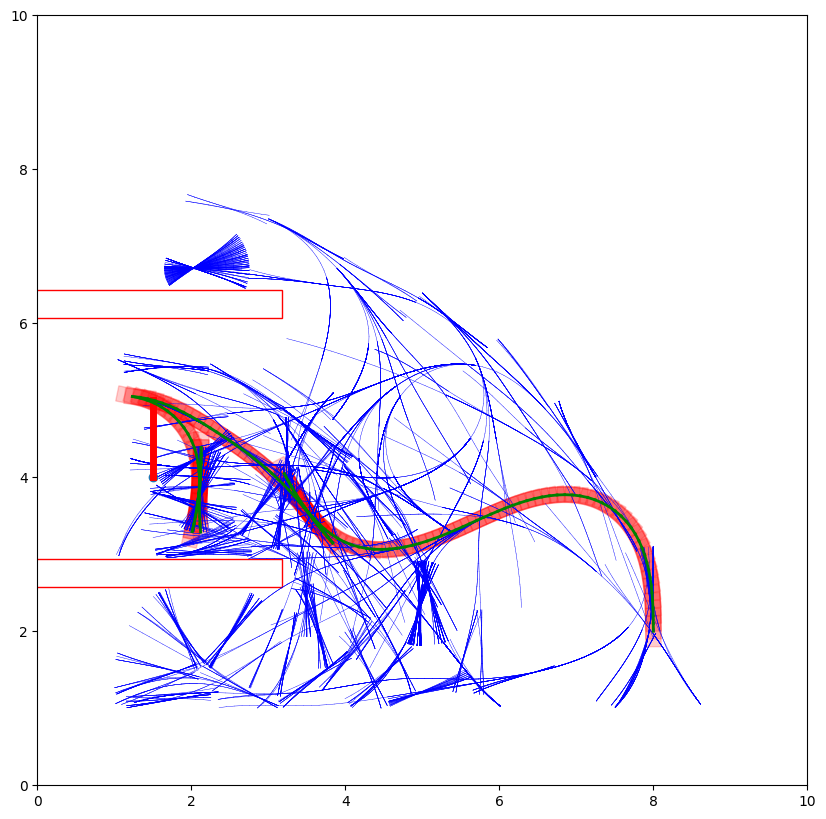

In [12]:
# node_list.append( goal_node_final)
if destination is None:
    destination = goal_node
    goal_node_final = goal_node
nodes = visualize(viz, node_list, destination, goal_node, obs, True)

In [ ]:
isOnSpot(destination, goal_node)

In [ ]:
isOnSpot(goal_node_final, goal_node)

In [ ]:
goal_node_final.getState()

In [ ]:
destination.getState()

In [ ]:
destination.getMove()

In [ ]:
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set(xlim=(0, 10), ylim = (0,10))
    ax = viz.addObstacles2Map(ax)
    ax.set_aspect("equal")

    i = 0
    y = goal_node.getState()[1]
    y_ = goal_node.getState()[1]
    ax.scatter(goal_node.getState()[0], y)
    theta = toRadian(goal_node.getState()[2])
    while(i<10):
        if goal_node.getState()[2] % 90 == 0:
            x = goal_node.getState()[0]
        else:
            x = y/math.tan(theta)
        i+=1
        y+=0.1
        y_-=0.1
        ax.scatter(x,y)
        ax.scatter(x,y_)


# Debugging 180 degree issue

In [ ]:
height, width = 10, 10
T = 0.5
dt = 0.1
threshold = 0.5
rand_map = [width-1, height-1]
start_point = [4,2,90,0]
obs = Obstacle(0.0)
viz = Visualization(obs)
start_node = Node(start_point, None, None, 0, [])

T = 1
u_linear = 1
u_steer1 = 0.5
u_steer2 = 0.7

In [ ]:
branches = getBranches(start_node, T, u_linear, u_steer1, u_steer2, obs)

In [ ]:
fig, ax = plt.subplots(figsize = (10, 10))
ax.set(xlim=(0, 10), ylim = (0,10))
ax = viz.addObstacles2Map(ax)
ax.set_aspect("equal")
for node in branches:
    start_node  = node.getParent()
    if start_node is not None:
        xi, yi, _, _ = start_node.getState()
        points = node.getPathArray()
        if points is not None:
            for point in points:
                xn, yn = point
                ax.plot([xi, xn], [yi, yn], color="blue", linewidth = 0.3)
                xi, yi = xn, yn

In [ ]:
math.tan(1.50)

In [ ]:
destination.getState()[2]

In [ ]:
# node_list.append( goal_node_final)
if destination is None:
    destination = goal_node
    goal_node_final = goal_node
nodes = visualize(viz, node_list, goal_node_final, goal_node, obs, False)

In [ ]:
if destination is None:
    destination = goal_node
    goal_node_final = goal_node
nodes = visualize(viz, node_list, goal_node_final, goal_node, obs, False)